# Importando as bibliotecas

In [1]:
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelBinarizer
import cv2
import mediapipe as mp
from IPython.display import clear_output
import kagglehub

# Carregando o modelo

In [2]:
model = keras.models.load_model("model_google_colab.keras")

model

<Sequential name=sequential_1, built=True>

# Teste do modelo usando uma webcam (OpenCV e MediaPipe)

Adaptado de um [repositório](https://github.com/WellingtonDev25/leitor_libras) do GitHub.

In [ ]:
cap = cv2.VideoCapture(0)
hands = mp.solutions.hands.Hands(max_num_hands=1)

classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 
           'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y']
try:
    while True:
        success, img = cap.read()
        
        if not success:
            continue
    
        frameRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        results = hands.process(frameRGB)
        handsPoints = results.multi_hand_landmarks
        h, w, _ = img.shape
        img_aux = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        if handsPoints != None:       
            for hand in handsPoints:
                x_max = 0
                y_max = 0
                x_min = w
                y_min = h
                
                for lm in hand.landmark:
                    x, y = int(lm.x * w), int(lm.y * h)
                    if x > x_max:
                        x_max = x
                    if x < x_min:
                        x_min = x
                    if y > y_max:
                        y_max = y
                    if y < y_min:
                        y_min = y

                cv2.rectangle(img, (x_min-50, y_min-50), (x_max+50, y_max+50), (0, 255, 0), 2)
    
                try:
                    imgCrop = img_aux[y_min-50:y_max+50, x_min-50:x_max+50]
                    imgCrop = cv2.resize(imgCrop, (28, 28))
                    imgCrop = imgCrop.reshape(-1, 28, 28, 1)
                    imgCrop = imgCrop / 255
                   
                    prediction_scores = model.predict(imgCrop)
                    predicted_value = prediction_scores.argmax()
                    predicted_label = classes[predicted_value]
                  
                    # Baseado em: https://gist.github.com/xcsrz/8938a5d4a47976c745407fe2788c813a
                    text_size = cv2.getTextSize(predicted_label, cv2.FONT_HERSHEY_COMPLEX, 3, 5)[0]
                    
                    text_x = int((img.shape[1] - text_size[0]) / 2)
                    text_y = int(img.shape[0] - (text_size[0] / 2))
    
                    cv2.putText(img, predicted_label, (text_x, text_y), cv2.FONT_HERSHEY_COMPLEX, 3, (0, 0, 255), 5)
                except:
                    continue
                    
        cv2.imshow('Kaggle - RNC - ASL', img)
        
        if cv2.waitKey(1) == 27: # ESC
            break
finally:
    cap.release()
    cv2.destroyAllWindows()

# Testes com o [conjunto de dados](https://www.kaggle.com/datasets/datamunge/sign-language-mnist) de treinamento do modelo

Baseado no [notebook](https://www.kaggle.com/code/sayakdasgupta/sign-language-classification-cnn-99-40-accuracy/notebook) de Sayak.

In [ ]:
dataset_path = kagglehub.dataset_download("datamunge/sign-language-mnist")

print("Caminho para os arquivos do dataset:", dataset_path)

In [5]:
test_df = pd.read_csv(dataset_path + '/sign_mnist_test.csv')

test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7172 entries, 0 to 7171
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 43.0 MB


## Visualização do conjunto de dados

In [6]:
test_df_images = test_df.drop_duplicates(subset="label", keep="first")
test_df_images = test_df_images.sort_values(by='label', ascending=True)

labels_imagens = test_df_images['label']
pixels_imagens = test_df_images.drop(['label'],axis=1)
pixels_imagens = pixels_imagens.values.reshape(-1, 28, 28, 1)

In [7]:
test_df_images.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24 entries, 3 to 88
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 147.4 KB


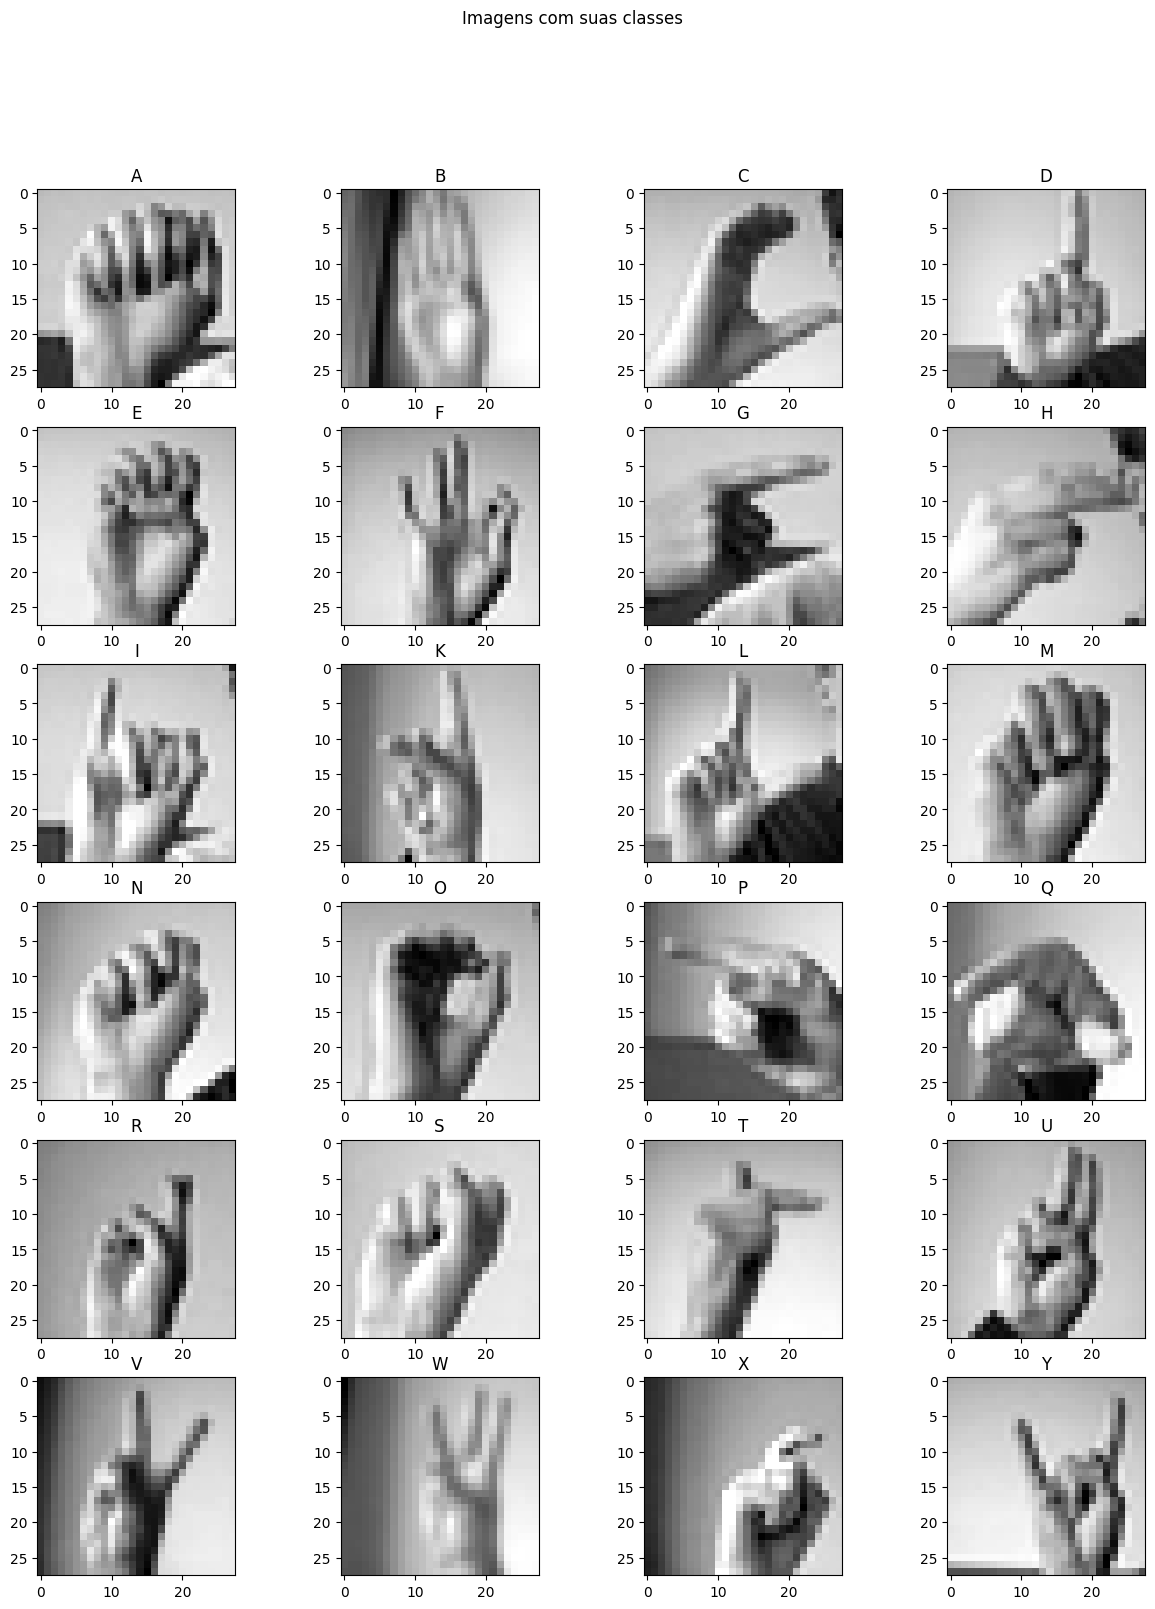

In [8]:
fig, axis=plt.subplots(6, 4, figsize=(15, 18))

classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 
           'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

fig.suptitle('Imagens com suas classes')

x = 0
y = 0
for label, img in zip(labels_imagens, pixels_imagens):
    axis[x][y].imshow(img, cmap="gray")

    true_label = classes[label]

    axis[x][y].set_title(true_label)

    y += 1
    if y > 3:
        y = 0
        x += 1

plt.show()

## Ajustando os dados para um formato utilizável

In [9]:
# Separando as features dos labels
test_label = test_df['label']
X_test = test_df.drop(['label'],axis=1)
print(X_test.shape)
X_test.head()

(7172, 784)


,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,149,149,150,150,150,151,151,150,151,152,...,138,148,127,89,82,96,106,112,120,107
1,126,128,131,132,133,134,135,135,136,138,...,47,104,194,183,186,184,184,184,182,180
2,85,88,92,96,105,123,135,143,147,152,...,68,166,242,227,230,227,226,225,224,222
3,203,205,207,206,207,209,210,209,210,209,...,154,248,247,248,253,236,230,240,253,255
4,188,191,193,195,199,201,202,203,203,203,...,26,40,64,48,29,46,49,46,46,53


In [10]:
# Convertendo o label de valor numérico para uma lista de zeros e uns
lb = LabelBinarizer()
y_test = lb.fit_transform(test_label)

y_test

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]])

In [11]:
# Ajustando as dimensões das features para o padrão correto de imagens (28x28) com um canal de cor (preto e branco)
X_test = X_test.values.reshape(-1, 28, 28, 1)

X_test.shape, y_test.shape

((7172, 28, 28, 1), (7172, 24))

In [12]:
# Convertendo os valores das features para valores entre 0 e 1
X_test = X_test / 255

In [13]:
X_test.shape, y_test.shape

((7172, 28, 28, 1), (7172, 24))

In [14]:
model.evaluate(x=X_test, y=y_test)

225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9955 - loss: 0.0198


[0.018922684714198112, 0.996374785900116]

## Testes com grupos de dados

In [15]:
predicted = model.predict(X_test[0:1])
print(y_test[0:1])
print(predicted)
print(f'Posição da classe real: {y_test[0:1].argmax()}')
print(f'Posição da classe prevista: {predicted.argmax()}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
[[8.4561104e-16 3.1402700e-14 2.5361251e-08 1.0478968e-16 5.3924443e-13
  2.3723555e-13 9.9987626e-01 1.9747211e-05 8.7662669e-17 4.2513930e-19
  5.3246697e-14 1.0237216e-09 1.1797598e-10 2.7229884e-08 1.8483195e-08
  1.0394489e-04 7.8979397e-17 7.5764746e-14 5.0508348e-10 3.2523079e-16
  2.1395271e-21 1.9004911e-20 1.1999473e-08 3.2496464e-13]]
Posição da classe real: 6
Posição da classe prevista: 6


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


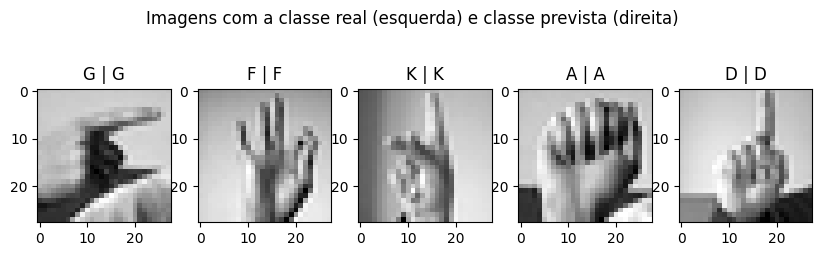

In [16]:
fig, axis=plt.subplots(1, 5, figsize=(10,3))

classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 
           'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y']
y_true = []
y_predict = []

fig.suptitle('Imagens com a classe real (esquerda) e classe prevista (direita)')

for ax, img, label in zip(axis, X_test[:5], y_test[:5]):
    ax.imshow(img, cmap="gray")
    
    img = img.reshape(-1, 28, 28, 1)
    
    prediction_scores = model.predict(img)
    predicted_value = prediction_scores.argmax()
    predicted_label = classes[predicted_value]
    true_label = classes[label.argmax()]

    y_predict.append(predicted_value)
    y_true.append(label.argmax())

    ax.set_title(f'{true_label} | {predicted_label}')

plt.show()

## Teste sobre todos os dados do conjunto de dados

In [17]:
classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 
           'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y']
y_true = []
y_predict = []

for img, label in zip(X_test, y_test):
    img = img.reshape(-1, 28, 28, 1)
    
    prediction_scores = model.predict(img)
    predicted_value = prediction_scores.argmax()
    predicted_label = classes[predicted_value]
    true_label = classes[label.argmax()]

    y_predict.append(predicted_value)
    y_true.append(label.argmax())

    clear_output(wait=True)
    print(f'{true_label} | {predicted_label}')

C | C


### Métricas dos resultados

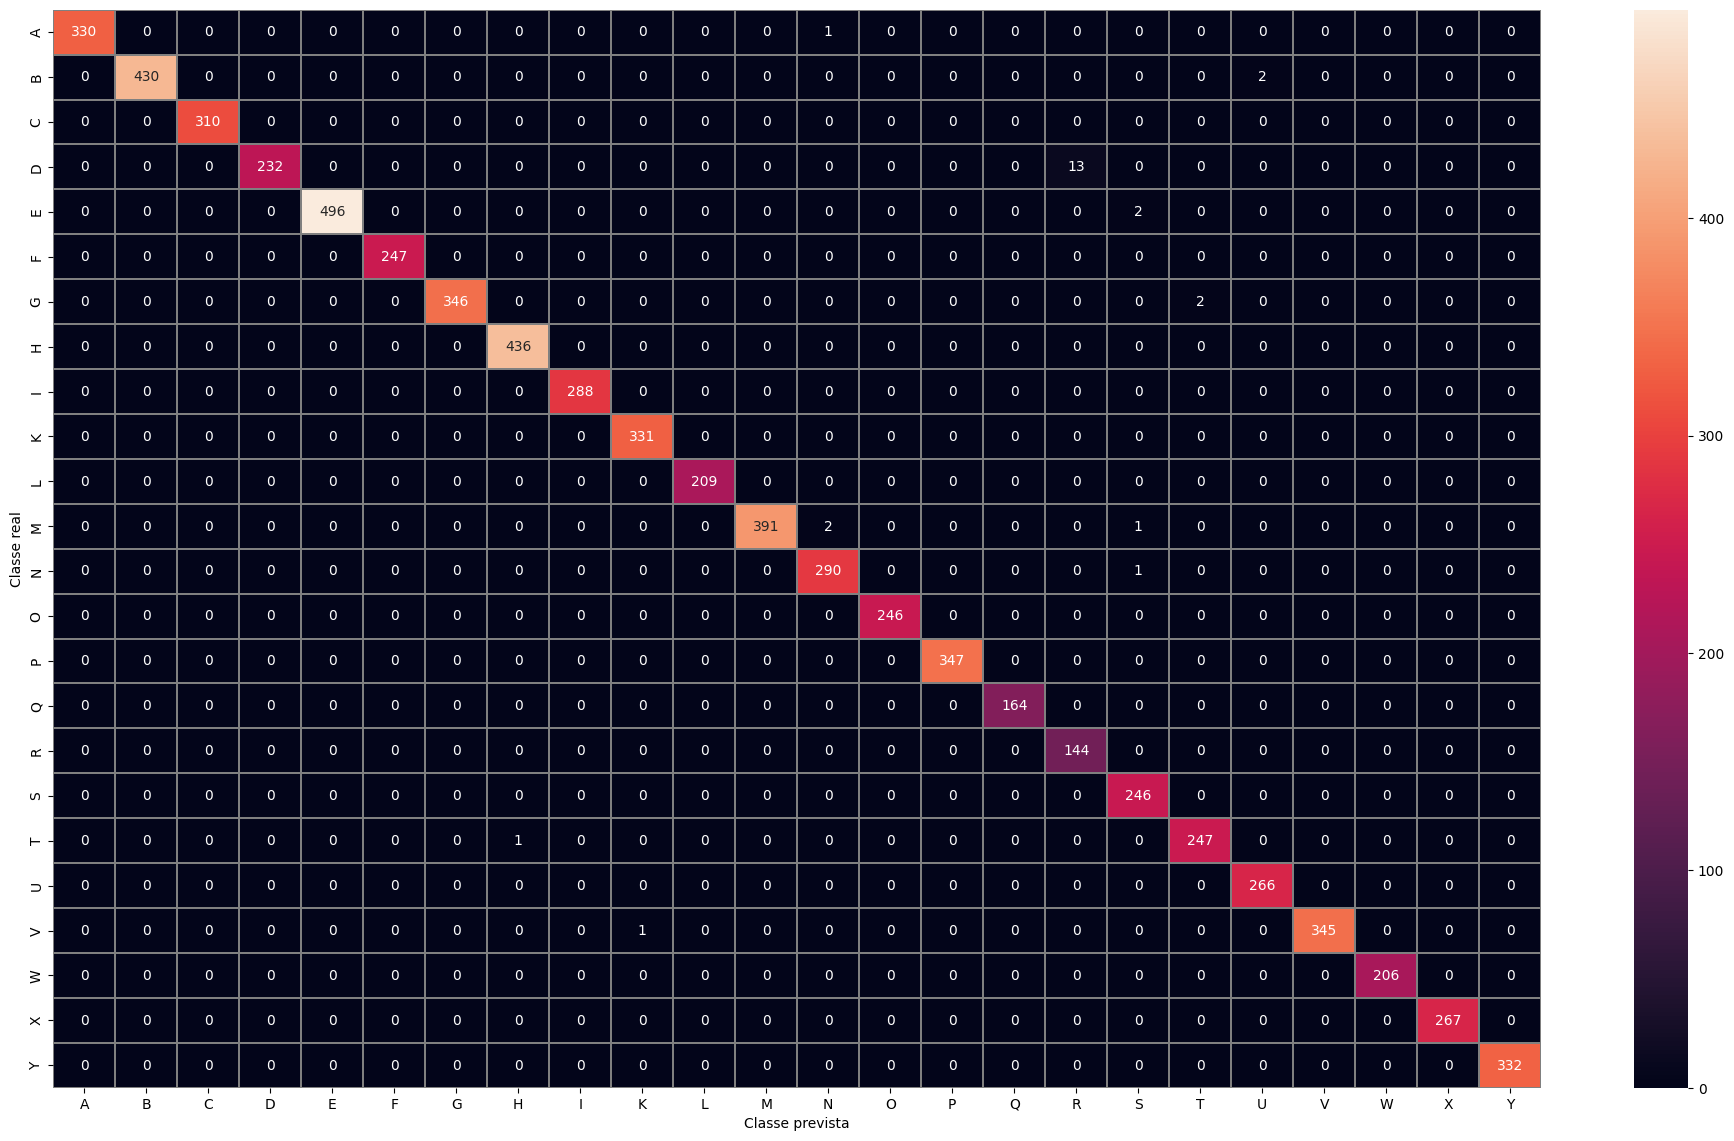

Acurácia: 0.9963747908533185


In [18]:
cf = confusion_matrix(y_true, y_predict, labels=[i for i in range(len(classes))])
df_cm = pd.DataFrame(cf, index = [i for i in classes], columns = [i for i in classes])

plt.figure(figsize = (24,14))

sn.heatmap(df_cm, linewidths=.1, linecolor='gray', annot=True, fmt="d")

plt.xlabel('Classe prevista')
plt.ylabel('Classe real')

#plt.savefig('confusion_matrix.png')
plt.show()

accuracy = accuracy_score(y_true, y_predict)

print(f'Acurácia: {accuracy}')

# Testes com o [dataset](https://www.kaggle.com/datasets/grassknoted/asl-alphabet) do usuário do Kaggle Akash

In [ ]:
dataset_path = kagglehub.dataset_download("grassknoted/asl-alphabet")

print("Path to dataset files:", dataset_path)

dataset_path = dataset_path + '/asl_alphabet_train/asl_alphabet_train'

## Visualização dos dados

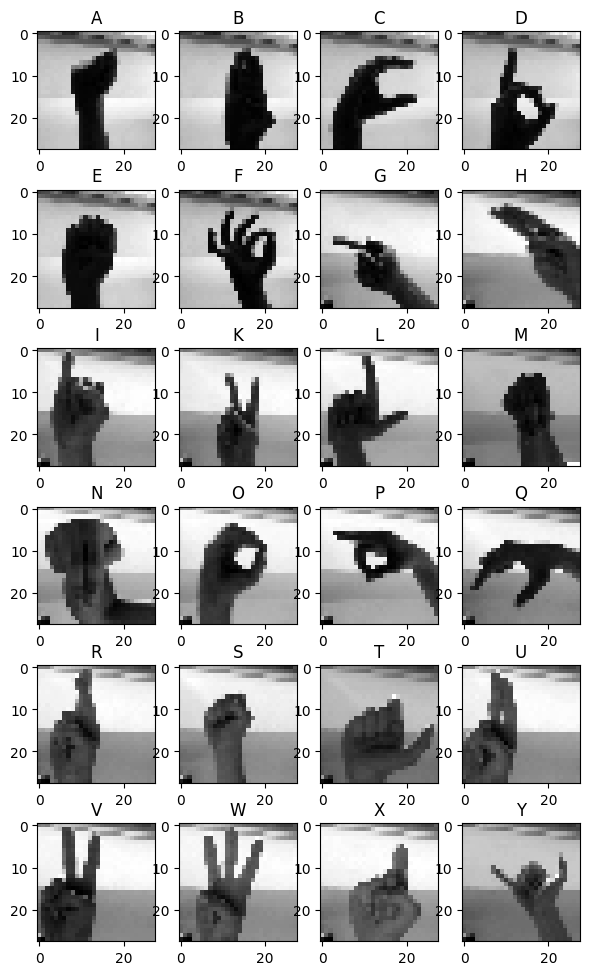

In [20]:
classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 
           'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y']

images = []

for x in range(len(classes)):
    file_path = f'{dataset_path}/{classes[x]}/{classes[x]}{1}.jpg'

    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)   
    image = cv2.resize(image, (28, 28))

    images.append([image])

plt.figure(figsize = (7, 12))

for i in range(24):
    plt.subplot(6, 4, i + 1)
    plt.title(classes[i])
    plt.imshow(images[i][0], cmap="gray")

## Métricas

In [22]:
classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 
           'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y']
y_true = []
y_predict = []

for x in range(len(classes)):
    for y in range(1, 3001):
        file_path = f'{dataset_path}/{classes[x]}/{classes[x]}{y}.jpg'
    
        image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (28, 28))
        image = image.reshape(-1, 28, 28, 1)
        image = image / 255
    
        prediction_scores = model.predict(image)
        predicted_value = prediction_scores.argmax()
        predicted_label = classes[predicted_value]
    
        y_predict.append(predicted_value)
        y_true.append(x)

        if y % 150 == 0:
            clear_output(wait=True)
            print(f'{dataset_path}\\{classes[x]}')    

C:\Users\guilh\.cache\kagglehub\datasets\grassknoted\asl-alphabet\versions\1/asl_alphabet_train/asl_alphabet_train\Y


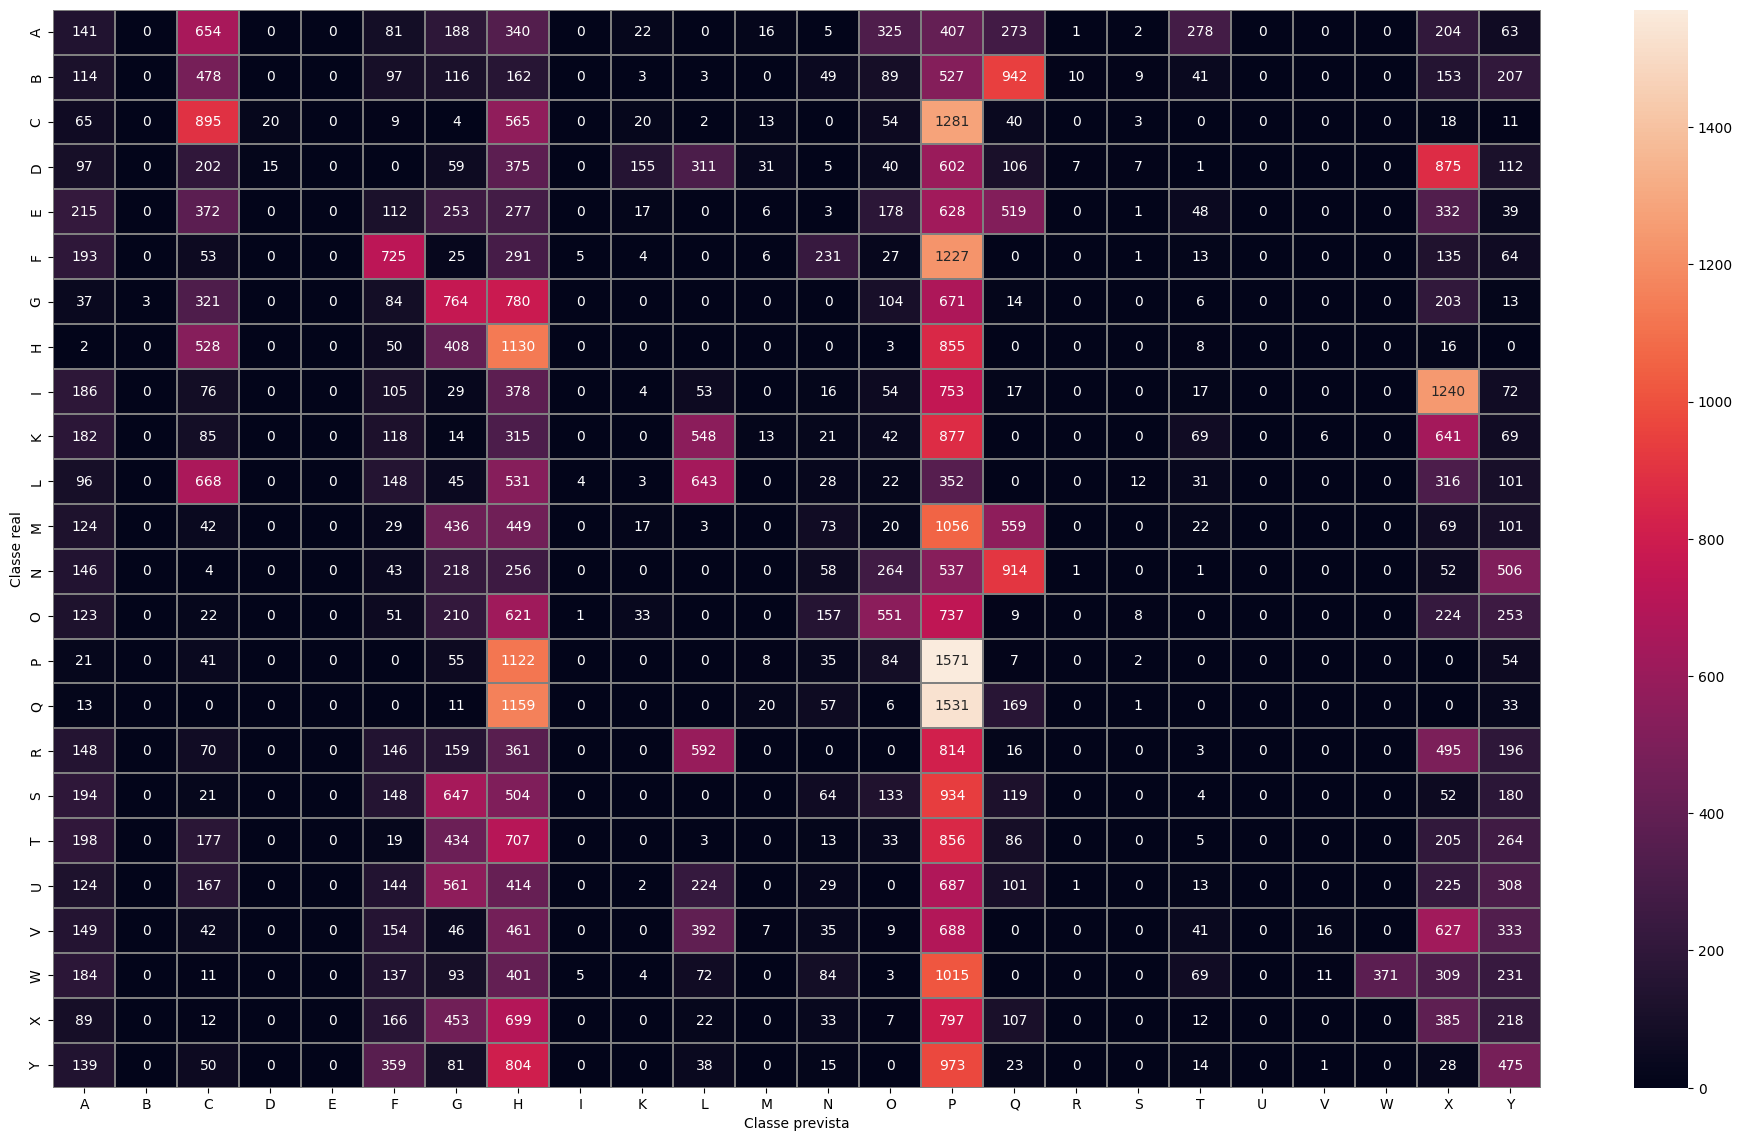

Acurácia: 0.10991666666666666


In [23]:
cf = confusion_matrix(y_true, y_predict, labels=[i for i in range(len(classes))])
df_cm = pd.DataFrame(cf, index = [i for i in classes], columns = [i for i in classes])

plt.figure(figsize = (24,14))

sn.heatmap(df_cm, linewidths=.1, linecolor='gray', annot=True, fmt="d")

plt.xlabel('Classe prevista')
plt.ylabel('Classe real')

#plt.savefig('confusion_matrix.png')
plt.show()

accuracy = accuracy_score(y_true, y_predict)

print(f'Acurácia: {accuracy}')

In [24]:
lb = LabelBinarizer()
y_true_bin = lb.fit_transform(y_true)

y_true_bin

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]])

In [26]:
classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 
           'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y']

images = np.ndarray(shape=(1, 28, 28, 1), dtype=np.float64)

for x in range(len(classes)):
    aux_images = np.ndarray(shape=(1, 28, 28, 1), dtype=np.float64)
    for y in range(1, 3001):
        file_path = f'{dataset_path}\\{classes[x]}\\{classes[x]}{y}.jpg'
    
        image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (28, 28))
        image = image.reshape(-1, 28, 28, 1)
        image = image / 255

        if y == 1:
            aux_images = np.array(image)
        else:
            aux_images = np.concatenate((aux_images, image), axis=0)
            
        if y % 150 == 0:
            clear_output(wait=True)
            print(f'{classes[x]} | {y}')

    if x == 0:
        images = np.copy(aux_images)
    else:
        images = np.concatenate((images, aux_images), axis=0)

Y | 3000


In [27]:
images.shape, y_true_bin.shape

((72000, 28, 28, 1), (72000, 24))

In [28]:
model.evaluate(x=images, y=y_true_bin)

2250/2250 ━━━━━━━━━━━━━━━━━━━━ 26s 12ms/step - accuracy: 0.1092 - loss: 18.6833


[18.311656951904297, 0.10991666465997696]